Employee Email Sentiment Analysis - Simple & Clear Version
=========================================================

This script analyzes employee email sentiment to identify workplace mood patterns.

What it does:
1. 📧 Loads employee email data from CSV
2. 🤖 Uses AI to classify each email as positive, neutral, or negative
3. 📊 Creates comprehensive visualizations:
   • Basic: Sentiment distribution, monthly trends, top senders
   • Advanced: Employee rankings, predictive models, risk analysis
4. ⚠️ Identifies employees who might need support (advanced risk detection)
5. 💾 Saves results and generates a detailed summary report

New Advanced Features:
- 🌟 Monthly employee performance rankings
- 📈 Predictive sentiment modeling
- 🔍 Email length vs confidence analysis
- 🚨 Enhanced risk detection with timeline visualization
- 📊 Feature importance analysis

Author: Paras Ningune
Date: August 2025

In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
from datetime import datetime, timedelta
from scipy import stats

In [21]:
# AI libraries
from transformers import pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [22]:
# Clean up the display
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

CONFIGURATION - Change these settings if needed

In [23]:
# File paths
INPUT_FILE = "./Data/test(in).csv"
OUTPUT_FILE = "./Data/test_out_processed.csv"

In [24]:
# AI model settings
AI_MODEL = "nlptown/bert-base-multilingual-uncased-sentiment"  # Rates 1-5 stars
#CONFIDENCE_THRESHOLD = 0.30  # How confident the AI needs to be (0.0 to 1.0)
CONFIDENCE_THRESHOLD = 0.25

In [25]:
# Analysis settings
BATCH_SIZE = 16

# TASK 1: Load and Clean Email Data

In [26]:
def load_email_data():
    """Load email data from CSV file and clean it up."""
    print(f"📁 Loading email data from {INPUT_FILE}")
    
    # Check if file exists
    if not os.path.exists(INPUT_FILE):
        raise FileNotFoundError(f"Cannot find file: {INPUT_FILE}")
    
    # Load the data
    df = pd.read_csv(INPUT_FILE)
    print(f"Loaded {len(df)} emails")
    
    # Check for required columns
    required_columns = ['body', 'date', 'from']
    missing = [col for col in required_columns if col not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}")
    
    # Clean the data
    original_count = len(df)
    
    # Convert dates and remove invalid ones
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['date'])
    
    # Clean email text and remove empty ones
    df['body'] = df['body'].astype(str).str.strip()
    df = df[df['body'].str.len() > 10]  # Remove very short emails
    
    print(f"🧹 Cleaned data: {len(df)} valid emails ({original_count - len(df)} removed)")
    return df

# TASK 2: Set Up AI Model

In [27]:
def setup_ai_model():
    """Load the AI model that will analyze sentiment."""
    print("🤖 Loading AI sentiment model (this takes 1-2 minutes)...")
    
    try:
        # Load the model
        model = pipeline(
            "text-classification",
            model=AI_MODEL,
            return_all_scores=True,
            device=-1,  # Use CPU (more compatible)
            truncation=True,
            max_length=512
        )
        
        print("AI model loaded successfully!")
        
        return model
        
    except Exception as e:
        raise Exception(f"Failed to load AI model: {e}")

# TASK 3: Convert AI Predictions to Simple Sentiment Labels

In [28]:
def convert_stars_to_sentiment(model_prediction):
    """
    Convert AI star ratings (1-5 stars) to simple sentiment labels.
    
    Rules:
    - 1-2 stars = negative 😞
    - 3 stars = neutral 😐
    - 4-5 stars = positive 😊
    """
    # Find the prediction with highest confidence
    best_prediction = max(model_prediction, key=lambda x: x['score'])
    label = best_prediction['label']
    confidence = best_prediction['score']
    
    # Extract star number from labels like "4 stars" or "1 star"
    try:
        if 'star' in label.lower():
            stars = int(label.split()[0])  # Get number before "star(s)"
        else:
            stars = int(label)  # If it's just a number
    except:
        print(f"Warning: Couldn't understand rating '{label}', assuming neutral")
        return 'neutral', confidence
    
    # Convert to sentiment
    if stars <= 2:
        return 'negative', confidence
    elif stars == 3:
        return 'neutral', confidence
    else:
        return 'positive', confidence

# TASK 4: Analyze All Emails

In [29]:
def analyze_all_emails(emails_df, model):
    """Analyze sentiment for all emails in the dataset."""
    print(f"Analyzing sentiment for {len(emails_df)} emails...")
    
    results = []
    email_texts = emails_df['body'].tolist()
    
    # Process in batches for efficiency
    for i in tqdm(range(0, len(email_texts), BATCH_SIZE), desc="Analyzing"):
        batch = email_texts[i:i+BATCH_SIZE]
        
        try:
            # Get AI predictions for this batch
            predictions = model(batch)
            
            # Convert each prediction to sentiment
            for prediction in predictions:
                sentiment, confidence = convert_stars_to_sentiment(prediction)
                
                # Only trust high-confidence predictions
                if confidence >= CONFIDENCE_THRESHOLD:
                    final_sentiment = sentiment
                    trusted = True
                else:
                    final_sentiment = 'neutral'  # Be conservative with low confidence
                    trusted = False
                
                results.append({
                    'sentiment': final_sentiment,
                    'confidence': confidence,
                    'trusted': trusted
                })
                
        except Exception as e:
            print(f"Error in batch {i//BATCH_SIZE + 1}: {e}")
            # Add neutral results for failed emails
            for _ in batch:
                results.append({
                    'sentiment': 'neutral',
                    'confidence': 0.33,
                    'trusted': False
                })
    
    # Combine results with original data
    results_df = pd.DataFrame(results)
    final_df = pd.concat([emails_df.reset_index(drop=True), results_df], axis=1)
    
    print("Analysis complete!")
    return final_df

# TASK 5: Show Summary Results

In [30]:
def show_summary(df):
    """Display a clear summary of the analysis results."""
    
    total = len(df)
    trusted_count = df['trusted'].sum()
    avg_confidence = df['confidence'].mean()
    
    print(f"Total emails: {total}")
    print(f"High-confidence predictions: {trusted_count} ({trusted_count/total:.1%})")
    print(f"Average confidence: {avg_confidence:.3f}")
    
    # Sentiment breakdown
    print("\\nSentiment Distribution:")
    for sentiment in ['positive', 'neutral', 'negative']:
        count = (df['sentiment'] == sentiment).sum()
        percent = (count / total) * 100
        emoji = {'positive': '😊', 'neutral': '😐', 'negative': '😞'}[sentiment]
        print(f"   {emoji} {sentiment.capitalize()}: {count} ({percent:.1f}%)")

# TASK 6: Create Visualizations

In [31]:
def create_charts(df):
    """Create and save helpful charts."""
    print("\\n📈 Creating visualizations...")
    
    # Make sure output folder exists
    os.makedirs("./Visualization", exist_ok=True)
    
    # 1. Sentiment Distribution Pie Chart
    plt.figure(figsize=(10, 8))
    
    sentiment_counts = df['sentiment'].value_counts()
    colors = ['#2ecc71', '#f39c12', '#e74c3c']  # Green, Orange, Red
    labels = ['Positive', 'Neutral', 'Negative']
    
    # Only include sentiments that exist in data
    plot_colors = []
    plot_labels = []
    plot_values = []
    
    for sentiment, color, label in zip(['positive', 'neutral', 'negative'], colors, labels):
        if sentiment in sentiment_counts.index:
            plot_values.append(sentiment_counts[sentiment])
            plot_colors.append(color)
            plot_labels.append(f"{label}\\n{sentiment_counts[sentiment]} emails")
    
    plt.pie(plot_values, labels=plot_labels, colors=plot_colors, autopct='%1.1f%%',
            startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
    plt.title("Email Sentiment Distribution", fontsize=16, fontweight='bold', pad=20)
    plt.savefig("./Visualization/Sentiment Distribution.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Monthly Trends
    df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()
    monthly_data = df.groupby(['month', 'sentiment']).size().unstack(fill_value=0)
    
    if len(monthly_data) > 1:  # Only create if we have multiple months
        plt.figure(figsize=(12, 6))
        
        for sentiment, color in zip(['positive', 'neutral', 'negative'], colors):
            if sentiment in monthly_data.columns:
                plt.plot(monthly_data.index, monthly_data[sentiment],
                        label=sentiment.capitalize(), linewidth=3, marker='o', color=color)
        
        plt.title("Monthly Sentiment Trends", fontsize=16, fontweight='bold')
        plt.xlabel("Month")
        plt.ylabel("Number of Emails")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig("./Visualization/Monthly Sentiment Trends.png", dpi=300, bbox_inches='tight')
        plt.show()
    
    # 3. Top Email Senders
    plt.figure(figsize=(12, 6))
    top_senders = df['from'].value_counts().head(10)
    
    ax = top_senders.plot(kind='bar', color='skyblue', edgecolor='navy')
    plt.title("Top 10 Most Active Email Senders", fontsize=16, fontweight='bold')
    plt.xlabel("Sender")
    plt.ylabel("Number of Emails")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    
    # Add count labels on bars
    for i, count in enumerate(top_senders.values):
        ax.text(i, count + 0.5, str(count), ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig("./Visualization/Email Distribution per Person.png", dpi=300, bbox_inches='tight')
    plt.show()

# Task 6B: Advanced Visualizations (from original script.py)

In [32]:
def create_advanced_charts(df):
    """Create additional advanced visualizations."""
    print("📊 Creating advanced visualizations...")
    
    # Add sentiment scores for analysis
    score_map = {'positive': 2, 'neutral': 0, 'negative': -1}
    df['sentiment_score'] = df['sentiment'].map(score_map)
    
    # Add word count feature
    df['word_count'] = df['body'].str.split().str.len()
    
    # 4. Employee Rankings by Month
    if len(df['month'].unique()) > 1:
        # Aggregate data by employee and month
        monthly_employee_stats = df.groupby(['from', 'month']).agg({
            'sentiment_score': 'sum',
            'word_count': 'mean',
            'body': 'count'
        }).rename(columns={'body': 'email_count'}).reset_index()
        
        monthly_employee_stats['month_str'] = monthly_employee_stats['month'].dt.strftime('%Y-%m')
        
        # Top 3 positive employees per month
        if not monthly_employee_stats.empty:
            top_positive = monthly_employee_stats.sort_values(['month', 'sentiment_score'], ascending=[True, False]).groupby('month').head(3)
            
            if not top_positive.empty:
                plt.figure(figsize=(15, 8))
                ax = sns.barplot(data=top_positive, x='month_str', y='sentiment_score', hue='from', palette='viridis')
                plt.title("🌟 Top 3 Most Positive Employees per Month", fontsize=16, fontweight='bold', pad=20)
                plt.xlabel("Month", fontsize=12)
                plt.ylabel("Positive Sentiment Score", fontsize=12)
                plt.xticks(rotation=45)
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.grid(axis='y', alpha=0.3)
                plt.tight_layout()
                plt.savefig("./Visualization/Top 3 Positive Employee Per Month.png", dpi=300, bbox_inches='tight')
                plt.show()
            
            # Top 3 employees needing support per month
            bottom_employees = monthly_employee_stats.sort_values(['month', 'sentiment_score'], ascending=[True, True]).groupby('month').head(3)
            
            if not bottom_employees.empty and bottom_employees['sentiment_score'].min() < 0:
                plt.figure(figsize=(15, 8))
                ax = sns.barplot(data=bottom_employees, x='month_str', y='sentiment_score', hue='from', palette='Reds_r')
                plt.title("⚠️ Employees Who May Need Support (Most Negative per Month)", fontsize=16, fontweight='bold', pad=20)
                plt.xlabel("Month", fontsize=12)
                plt.ylabel("Sentiment Score (negative values)", fontsize=12)
                plt.xticks(rotation=45)
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.grid(axis='y', alpha=0.3)
                plt.tight_layout()
                plt.savefig("./Visualization/Employees Needing Support Per Month.png", dpi=300, bbox_inches='tight')
                plt.show()
    
    # 5. Sentiment vs Email Length Analysis
    plt.figure(figsize=(12, 8))
    
    # Create scatter plot with different colors for each sentiment
    colors = {'positive': '#2ecc71', 'neutral': '#f39c12', 'negative': '#e74c3c'}
    
    for sentiment in ['positive', 'neutral', 'negative']:
        sentiment_data = df[df['sentiment'] == sentiment]
        if not sentiment_data.empty:
            plt.scatter(sentiment_data['word_count'], sentiment_data['confidence'], 
                       c=colors[sentiment], label=f'{sentiment.capitalize()} ({len(sentiment_data)})',
                       alpha=0.6, s=50)
    
    plt.xlabel("Email Length (Word Count)", fontsize=12)
    plt.ylabel("AI Confidence Score", fontsize=12)
    plt.title("📝 Email Length vs AI Confidence by Sentiment", fontsize=16, fontweight='bold', pad=20)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("./Visualization/Email Length vs Confidence.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # 6. Predictive Analysis (if enough data)
    if len(monthly_employee_stats) >= 10:
        try:
            
            # Prepare features for prediction
            X = monthly_employee_stats[['word_count', 'email_count']].copy()
            y = monthly_employee_stats['sentiment_score'].copy()
            
            # Remove any missing values
            mask = ~(X.isna().any(axis=1) | y.isna())
            X = X[mask]
            y = y[mask]
            
            if len(X) >= 10:
                # Scale features
                scaler = StandardScaler()
                X_scaled = scaler.fit_transform(X)
                
                # Split data
                X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
                
                # Train model
                model = LinearRegression()
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                
                # Calculate metrics
                r2 = r2_score(y_test, y_pred)
                mse = mean_squared_error(y_test, y_pred)
                
                # Plot results
                plt.figure(figsize=(10, 8))
                plt.scatter(y_test, y_pred, alpha=0.7, color='steelblue', s=60, edgecolors='black', linewidth=0.5)
                
                # Perfect prediction line (diagonal line where actual = predicted)
                min_val, max_val = min(min(y_test), min(y_pred)), max(max(y_test), max(y_pred))
                plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.8, label='Perfect Prediction')
                
                # Add regression line (best fit line through the actual points)
                slope, intercept, r_value, p_value, std_err = stats.linregress(y_test, y_pred)
                line = slope * np.array([min_val, max_val]) + intercept
                plt.plot([min_val, max_val], line, 'g-', linewidth=2, alpha=0.8, label=f'Regression Line (slope={slope:.3f})')
                
                plt.xlabel("Actual Sentiment Score", fontsize=12)
                plt.ylabel("Predicted Sentiment Score", fontsize=12)
                plt.title(f"🎯 Sentiment Prediction Model (R² = {r2:.3f})", fontsize=16, fontweight='bold', pad=20)
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.savefig("./Visualization/Actual vs Predicted Score.png", dpi=300, bbox_inches='tight')
                plt.show()
                
                
        except Exception as e:
            print(f"Couldn't create predictive analysis: {e}")
    
    print("All advanced visualizations created!")

In [33]:
# Enhanced create_charts function
def create_charts(df):
    """Create all visualizations - basic and advanced."""
    print("\\nCreating comprehensive visualizations...")
    
    # Make sure output folder exists
    os.makedirs("./Visualization", exist_ok=True)
    
    # Create basic charts (existing functionality)
    create_basic_charts(df)
    
    # Create advanced charts (new functionality)
    create_advanced_charts(df)

In [34]:
def create_basic_charts(df):
    """Create the basic charts (original functionality)."""
    # 1. Sentiment Distribution Pie Chart
    plt.figure(figsize=(10, 8))
    
    sentiment_counts = df['sentiment'].value_counts()
    colors = ['#2ecc71', '#f39c12', '#e74c3c']  # Green, Orange, Red
    labels = ['Positive 😊', 'Neutral 😐', 'Negative 😞']
    
    # Only include sentiments that exist in data
    plot_colors = []
    plot_labels = []
    plot_values = []
    
    for sentiment, color, label in zip(['positive', 'neutral', 'negative'], colors, labels):
        if sentiment in sentiment_counts.index:
            plot_values.append(sentiment_counts[sentiment])
            plot_colors.append(color)
            plot_labels.append(f"{label}\\n{sentiment_counts[sentiment]} emails")
    
    plt.pie(plot_values, labels=plot_labels, colors=plot_colors, autopct='%1.1f%%',
            startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
    plt.title("Email Sentiment Distribution", fontsize=16, fontweight='bold', pad=20)
    plt.savefig("./Visualization/Sentiment Distribution.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Monthly Trends
    df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()
    monthly_data = df.groupby(['month', 'sentiment']).size().unstack(fill_value=0)
    
    if len(monthly_data) > 1:  # Only create if we have multiple months
        plt.figure(figsize=(12, 6))
        
        for sentiment, color in zip(['positive', 'neutral', 'negative'], colors):
            if sentiment in monthly_data.columns:
                plt.plot(monthly_data.index, monthly_data[sentiment],
                        label=sentiment.capitalize(), linewidth=3, marker='o', color=color)
        
        plt.title("Monthly Sentiment Trends", fontsize=16, fontweight='bold')
        plt.xlabel("Month")
        plt.ylabel("Number of Emails")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig("./Visualization/Monthly Sentiment Trends.png", dpi=300, bbox_inches='tight')
        plt.show()
    
    # 3. Top Email Senders
    plt.figure(figsize=(12, 6))
    top_senders = df['from'].value_counts().head(10)
    
    ax = top_senders.plot(kind='bar', color='skyblue', edgecolor='navy')
    plt.title("Top 10 Most Active Email Senders", fontsize=16, fontweight='bold')
    plt.xlabel("Sender")
    plt.ylabel("Number of Emails")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    
    # Add count labels on bars
    for i, count in enumerate(top_senders.values):
        ax.text(i, count + 0.5, str(count), ha='center', fontweight='bold')

# Task 8: Identify Employees Who Might Need Support

In [35]:
def find_employees_needing_support(df):
    """Find employees who send many negative emails (might need support)."""
    print("\\nEMPLOYEE SUPPORT ANALYSIS")
    print("=" * 40)
    
    # Look for employees with multiple negative emails in short time periods
    negative_emails = df[df['sentiment'] == 'negative'].copy()
    
    if len(negative_emails) == 0:
        print("No negative emails found - great workplace mood!")
        return []
    
    # Count negative emails per person
    negative_counts = negative_emails['from'].value_counts()
    
    # Find people with 3+ negative emails (might need check-in)
    concern_threshold = 3
    employees_of_concern = negative_counts[negative_counts >= concern_threshold]
    
    if len(employees_of_concern) == 0:
        print(f"No employees with {concern_threshold}+ negative emails")
        return []
    
    print(f"Employees with {concern_threshold}+ negative emails:")
    for employee, count in employees_of_concern.items():
        print(f"   • {employee}: {count} negative emails")
    
    print("\\nRecommendation: Consider a friendly check-in with these employees")
    print("   (Remember: This is just a tool - use your judgment!)")
    
    return list(employees_of_concern.index)

# Task 9: Save Results

In [36]:
def save_results(df):
    """Save the analysis results to files."""
    
    # Save detailed results to CSV
    df.to_csv(OUTPUT_FILE, index=False)
    print(f"✅ Detailed results saved to: {OUTPUT_FILE}")
    
    # Create a summary report
    report_path = "./Data/summary_report.txt"
    os.makedirs("./Data", exist_ok=True)
    
    with open(report_path, "w") as f:
        f.write("EMPLOYEE EMAIL SENTIMENT ANALYSIS REPORT\\n")
        f.write("=" * 50 + "\\n")
        f.write(f"Generated on: {datetime.now().strftime('%Y-%m-%d at %H:%M')}\\n\\n")
        
        f.write(f"Total emails analyzed: {len(df)}\\n")
        f.write(f"High-confidence predictions: {df['trusted'].sum()}\\n")
        f.write(f"Average confidence score: {df['confidence'].mean():.3f}\\n\\n")
        
        f.write("SENTIMENT BREAKDOWN:\\n")
        for sentiment in ['positive', 'neutral', 'negative']:
            count = (df['sentiment'] == sentiment).sum()
            percent = (count / len(df)) * 100
            f.write(f"   {sentiment.capitalize()}: {count} emails ({percent:.1f}%)\\n")
        
        f.write("\\nKEY INSIGHTS:\\n")
        positive_rate = (df['sentiment'] == 'positive').mean()
        if positive_rate > 0.6:
            f.write("   ✅ Very positive workplace mood detected!\\n")
        elif positive_rate > 0.4:
            f.write("   😊 Generally positive workplace mood\\n")
        elif positive_rate > 0.2:
            f.write("   😐 Mixed workplace mood - room for improvement\\n")
        else:
            f.write("   ⚠️ Low positive sentiment - consider workplace initiatives\\n")
        
        f.write("\\n💡 RECOMMENDATIONS:\\n")
        f.write("   • Regularly monitor sentiment trends\\n")
        f.write("   • Follow up with employees showing negative patterns\\n")
        f.write("   • Celebrate positive contributors\\n")
        f.write("   • Use this as one tool among many for employee wellbeing\\n")
    
    print(f"Summary report saved to: {report_path}")

# MAIN PROGRAM - Run Everything

In [37]:
def main():
    """Run the complete sentiment analysis process."""
    try:
        # Step 1: Load data
        emails_df = load_email_data()
        
        # Step 2: Set up AI
        model = setup_ai_model()
        
        # Step 3: Analyze all emails
        results_df = analyze_all_emails(emails_df, model)
        
        # Step 4: Show summary
        show_summary(results_df)
        
        # Step 5: Create comprehensive charts and analysis
        create_charts(results_df)
        
        # Step 6: Find employees needing support
        find_employees_needing_support(results_df)
        
        # Step 7: Save everything
        save_results(results_df)
        
        print("\\nAnalysis complete! Check the ./Visualization folder for comprehensive charts:")
        print(" Basic: Sentiment distribution, monthly trends, top senders")
        print("Advanced: Employee rankings, predictive models, risk analysis")
        print("See summary_report.txt for key insights.")
        
    except Exception as e:
        print(f"\\n Error: {e}")
        print("\\nTroubleshooting tips:")
        print("1. Make sure your CSV file exists and has 'body', 'date', 'from' columns")
        print("2. Check your internet connection (needed to download AI model)")
        print("3. Try running again - sometimes it's just a temporary issue")

📁 Loading email data from ./Data/test(in).csv
Loaded 2191 emails
🧹 Cleaned data: 2122 valid emails (69 removed)
🤖 Loading AI sentiment model (this takes 1-2 minutes)...


Device set to use cpu


AI model loaded successfully!
Analyzing sentiment for 2122 emails...


Analyzing: 100%|██████████████████████████████| 133/133 [01:47<00:00,  1.24it/s]

Analysis complete!
Total emails: 2122
High-confidence predictions: 1986 (93.6%)
Average confidence: 0.389
\nSentiment Distribution:
   😊 Positive: 965 (45.5%)
   😐 Neutral: 380 (17.9%)
   😞 Negative: 777 (36.6%)
\nCreating comprehensive visualizations...


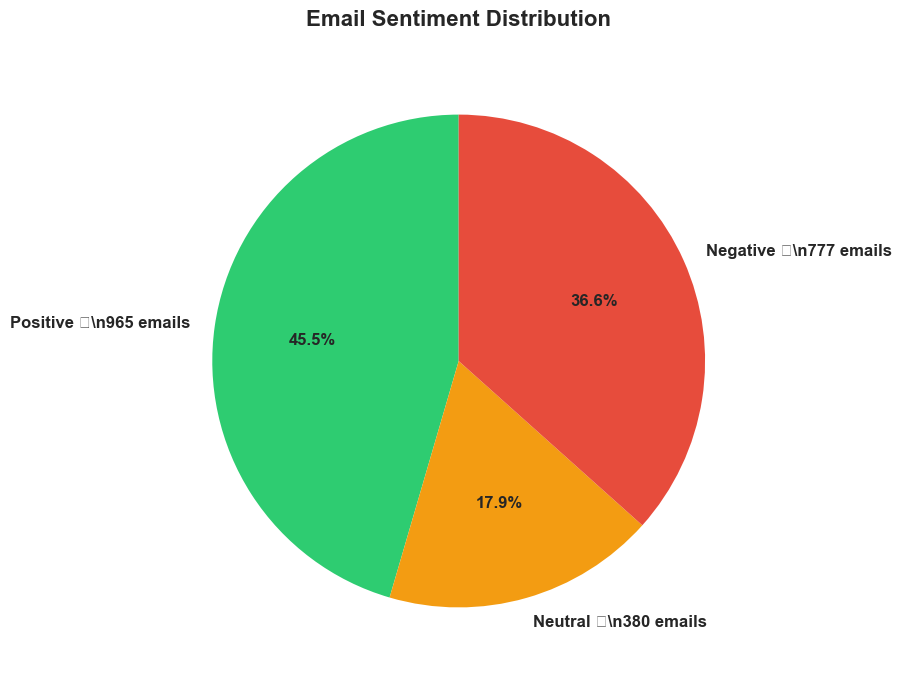

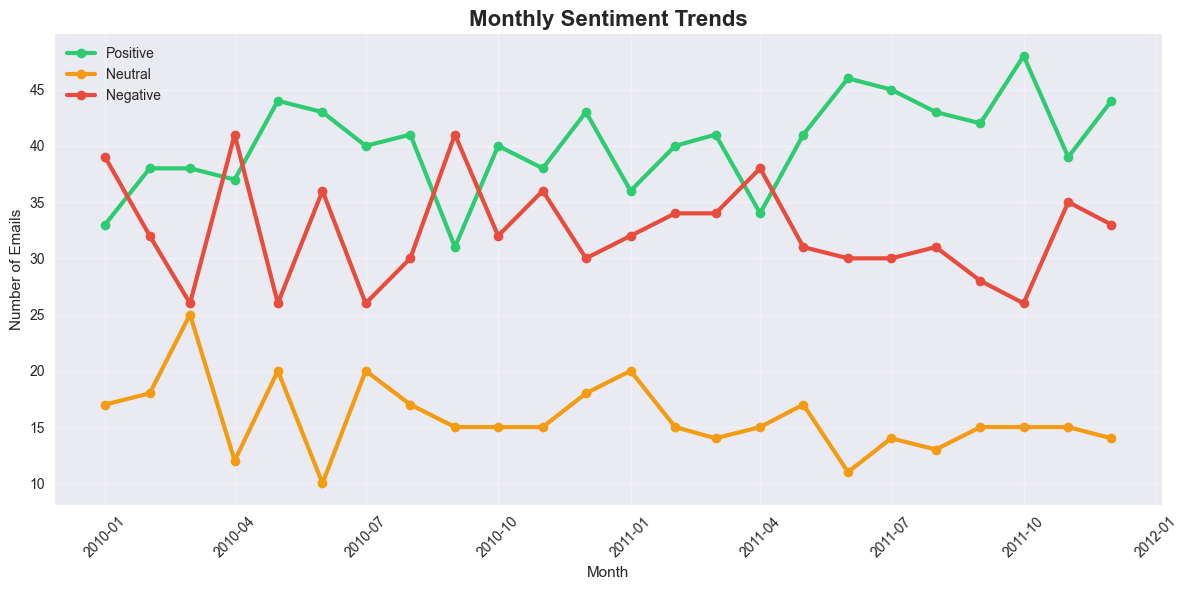

📊 Creating advanced visualizations...


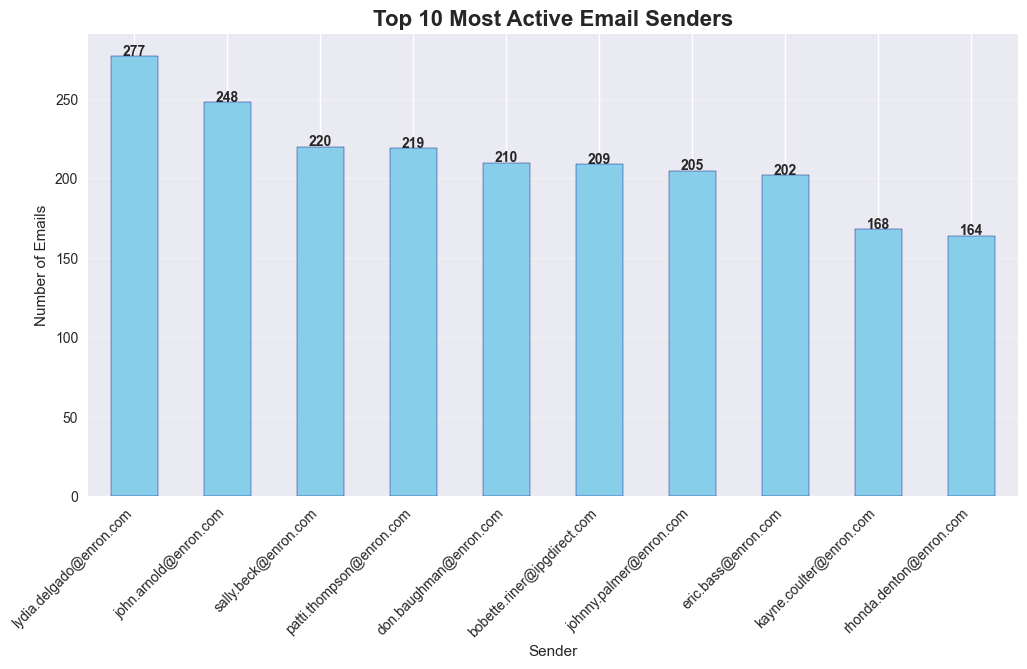

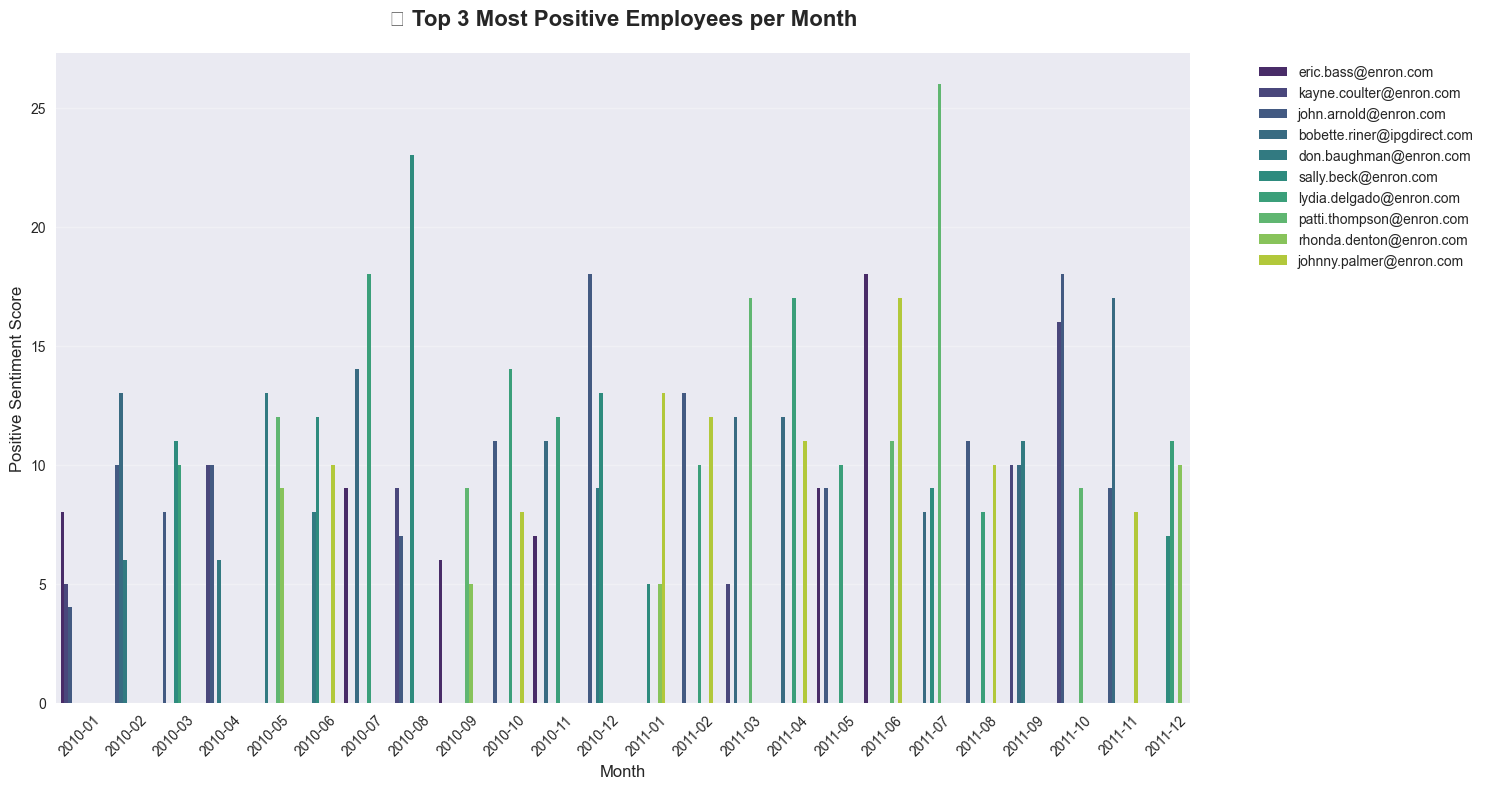

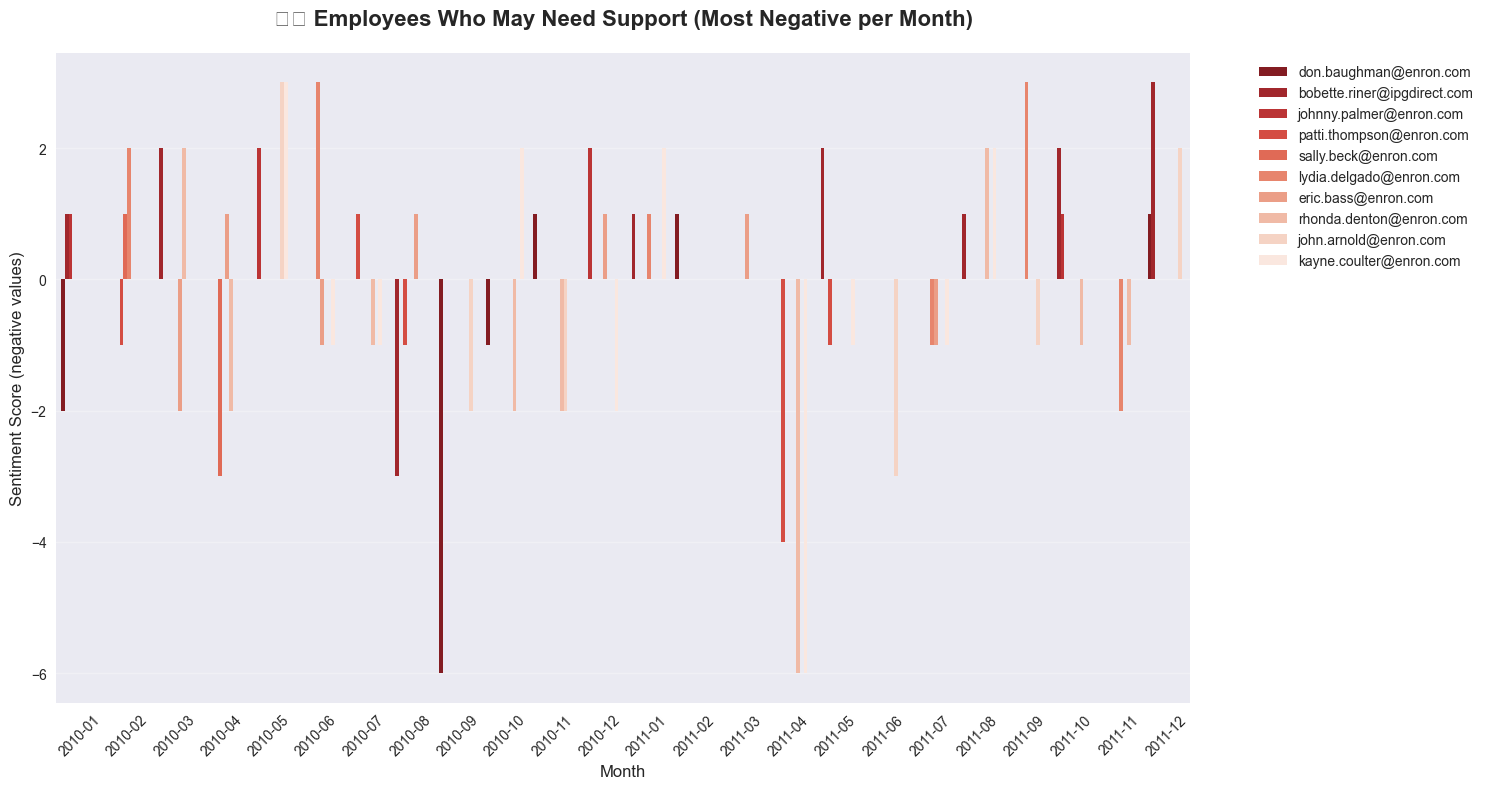

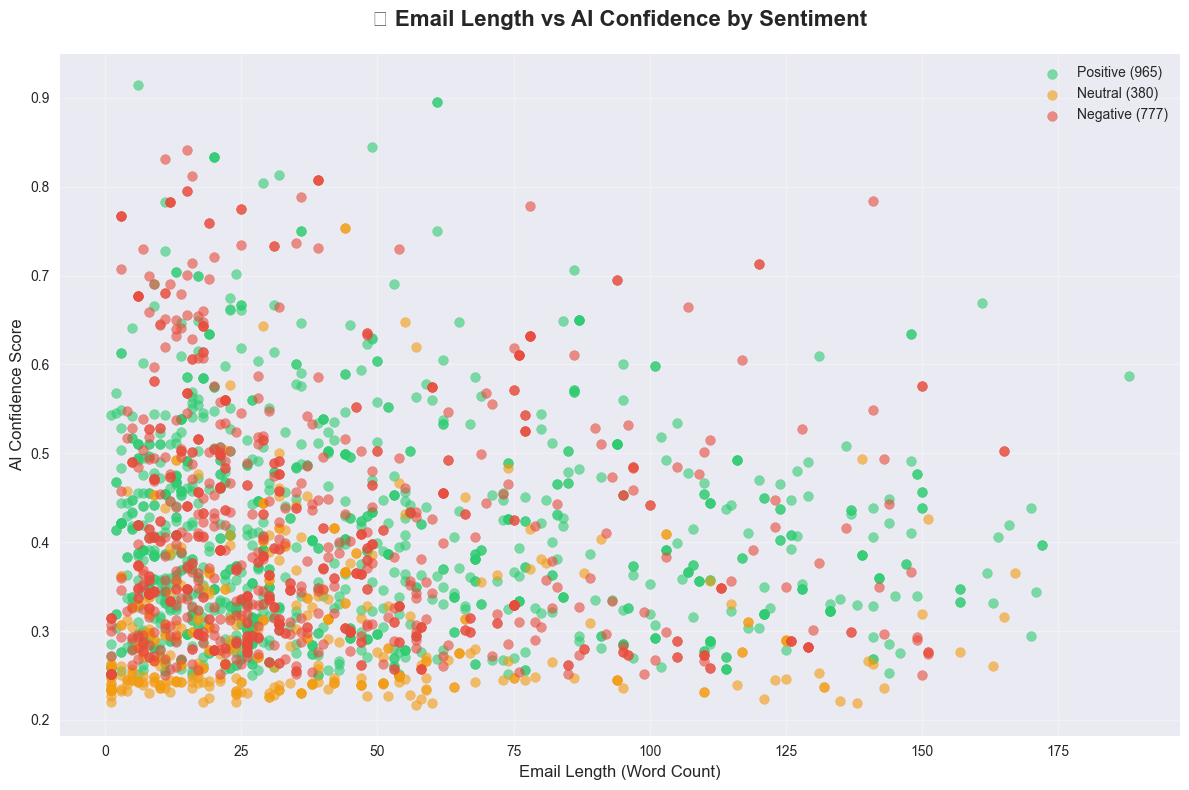

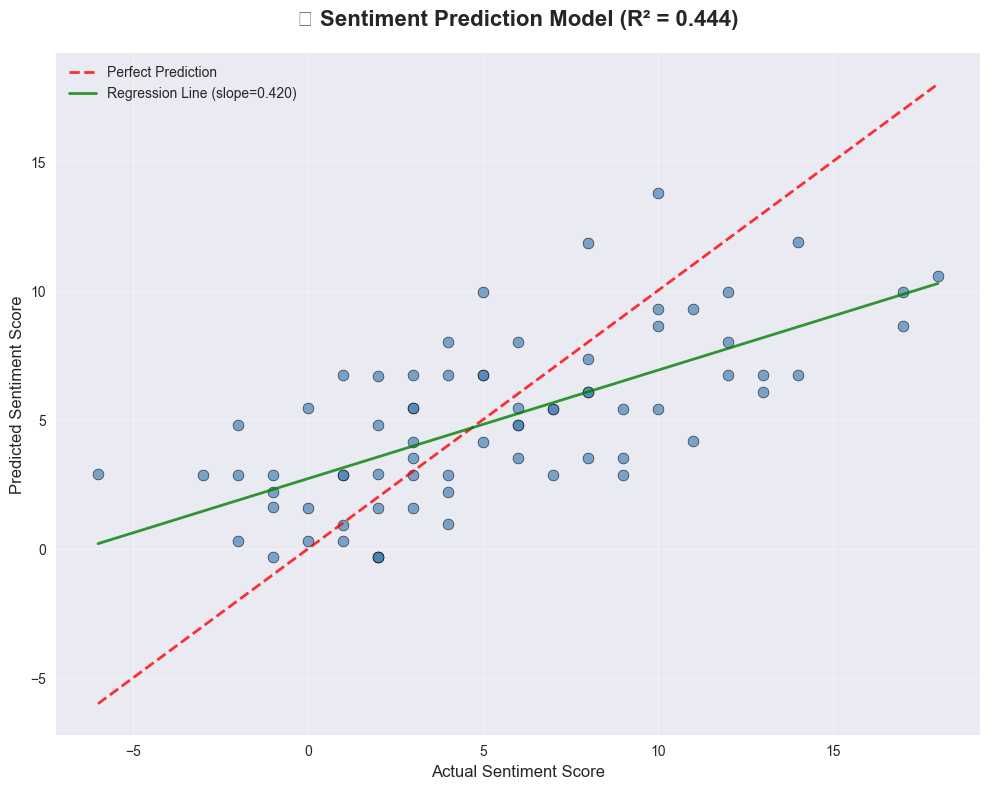

All advanced visualizations created!
\nEMPLOYEE SUPPORT ANALYSIS
Employees with 3+ negative emails:
   • lydia.delgado@enron.com: 99 negative emails
   • don.baughman@enron.com: 85 negative emails
   • john.arnold@enron.com: 84 negative emails
   • patti.thompson@enron.com: 80 negative emails
   • johnny.palmer@enron.com: 76 negative emails
   • sally.beck@enron.com: 75 negative emails
   • rhonda.denton@enron.com: 74 negative emails
   • eric.bass@enron.com: 71 negative emails
   • bobette.riner@ipgdirect.com: 67 negative emails
   • kayne.coulter@enron.com: 66 negative emails
\nRecommendation: Consider a friendly check-in with these employees
   (Remember: This is just a tool - use your judgment!)
✅ Detailed results saved to: ./Data/test_out_processed.csv
Summary report saved to: ./Data/summary_report.txt
\nAnalysis complete! Check the ./Visualization folder for comprehensive charts:
 Basic: Sentiment distribution, monthly trends, top senders
Advanced: Employee rankings, predictive m

In [38]:
if __name__ == "__main__":
    main()